[Open Data Córdoba](http://opendatacordoba.org/) es un colectivo abierto y multidisplinario sin fines de lucro cuyo objetivo principal es difundir y transparentar el uso de la tecnología y los datos masivos para beneficio del conjunto de la sociedad, especialmente en la provincia de Córdoba.

El grupo [nació](http://opendatacordoba.org/blog/democracia-con-codigos-asi-nacio-opendatacordoba/) en época de elecciones, intentando echar un manto de luz a las sospechas fundadas de desprolijidades en el escrutinio provisorio de las legislativas de 2013. Luego de muchas otras iniciativas y bastante perceberancia docente de algunos de nuestros compañeros, nuestra contribución ha empezado a ser reconocida desde los medios locales, algunas agrupaciones políticas y otras organizaciones de la sociedad civil que abogan por la transparencia y el fortalecimiento de las instituciones. 

En este contexto, el portal de noticias [Cba24N](http://www.cba24n.com.ar), perteneciente al grupo de Servicios de Radio y Televisión (SRT) de la Universidad Nacional de Córdoba, nos ha invitado a realizar análisis de datos "en vivo" el próximo 25 de octubre, día de las elecciones nacionales. 


Hay muchas [ideas para ese día](https://hackdash.org/dashboards/odc2015) que ojalá podamos llevar adelante, aunque vale resaltar (<strike>atajarse</strike>) que se trata de una tarea totalmente voluntaria . Mientras tanto, el domingo pasado me dediqué a jugar con algunas agregaciones sobre el padrón de Córdoba para encontrar "notas de color" analizando nombres y apellidos de los votantes

<!-- TEASER_END -->

### Dime tu nombre y te diré cómo te llamas 

*Cinco de cada diez hombres... son la mitad*, [analizaba Les Luthiers](https://www.youtube.com/watch?v=Sy_sVtJlG40) con mucho humor y precisión científica. Este análisis del padrón no pretende conclusiones mucho más elaboradas que esa (ni alcanzar semejantes cotas de gracia), pero con las herramientas de software libre actuales es fácil analizar (y graficar) algunas curiosidades. 

Por ejemplo ¿hay más cordobeses de apellido Pérez o González? ¿Cuantas personas tienen más de dos nombres? ¿Cuales son los nombres más comunes de cada década? 

Primero importo y configuro las herramientas principales, [Pandas](http://pandas.pydata.org/) y [Matplotlib](http://matplotlib.org/)

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
cba = pd.read_csv('padron_cba_2015.csv', usecols=['clase', 'apellido', 'nombres', 'sexo'])

In [3]:
cba.head()

,clase,apellido,nombres,sexo
0,1938,ABACA,CELINA DEL ROSARIO,F
1,1963,ABADJIAN,MARIA ALICIA SOL,F
2,1979,ABAL,CLARA,F
3,1922,ABALO,MARIA AZUCENA,F
4,1925,ABALO,YOLANDA JOSEFA,F


In [4]:
len(cba.index)

2783122

In [5]:
len(cba[cba['sexo'] == 'F'].index)/_, len(cba[cba['sexo'] == 'M'].index)/_

(0.5139293211005482, 0.48607067889945177)

In [6]:
cba.ix[cba['clase'].argmin()]

clase         1910
apellido    BASTUS
nombres     MIGUEL
sexo             M
Name: 328532, dtype: object

El [padrón que conseguimos](https://github.com/OpenDataCordoba/elecciones2015/tree/master/nombres)  es el que la Justicia Electoral provee a los partidos políticos para sus tareas de fiscalización. En particular el de la provincia de Córdoba tiene **2.78 millones de votantes habilitados** de los cuales el **51.4% son mujeres**. El más viejo es Don Miguel Bastus, de 105 años. 


### Normalizando y separando nombres

Si bien el dataset del padrón incluye mucha información como circuito de cada votante y por supuesto el DNI y otros datos sensibles que por cuestiones de protección de la privacidad nunca publicaríamos, en particular me interesaba desagregar los nombres, que vienen en una sola columna, en dos o más y normalizarlos a un formato común (cada nombre o apellido comienza con mayúscula)

In [7]:
cba.apellido = cba.apellido.apply(lambda v: v.title())
cba.nombres = cba.nombres.apply(lambda v: v.title())

Para separar los nombres voy a usar un [paquete](http://nameparser.readthedocs.org/en/latest/) que tiene un mínimo cuidado con casos particulares con los *van*, *del*, etc. que pueden aparecer en algunos apellidos. 

In [8]:
from nameparser import HumanName
def s(n):
    hn = HumanName(n)
    if hn.middle:
        return [hn.first, hn.middle, hn.last]
    return [hn.first, hn.last, hn.middle]

In [9]:
s('María Francisca')  # devuelve hasta tres nombres

['María', 'Francisca', '']

In [10]:
nombres_df = pd.DataFrame(cba['nombres'].apply(s).values.tolist(), 
                              columns=['primer_nombre', 'segundo_nombre', 'tercer_nombre'])

In [11]:
cba = pd.concat((cba.drop('nombres', 1), nombres_df), axis=1)
cba.head()

,clase,apellido,sexo,primer_nombre,segundo_nombre,tercer_nombre
0,1938,Abaca,F,Celina,Del Rosario,
1,1963,Abadjian,F,Maria,Alicia,Sol
2,1979,Abal,F,Clara,,
3,1922,Abalo,F,Maria,Azucena,
4,1925,Abalo,F,Yolanda,Josefa,


Ya tenemos el dataset como queríamos, podemos sacar algunas cuentas y, mejor, hacer algunos graficos!


#### Los 20 apellidos más comunes en Córdoba

Vemos que contra todo pronóstico, los Pérez apenas entran en el top 10 de apellidos más comunes y el 1.3% del padrón son los González! Quizás signifique el hallazgo de un nuevo *focus group* para campañas políticas. 


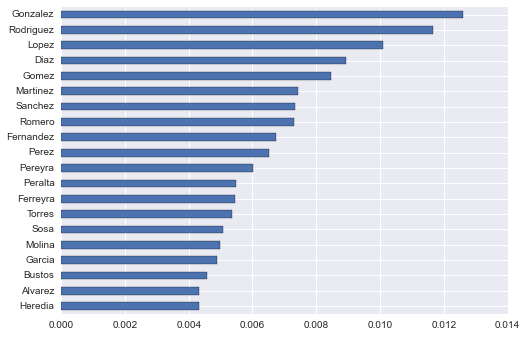

In [12]:
cba.apellido.value_counts(normalize=True)[:20].sort(inplace=False).plot('barh');

### Un nombre muy cordobés

La generación más jóven de votantes tiene entre 16 y 26 años. Entre las mujeres de esa edad, casi el 10% (más de 25 mil cordobesas) tiene como primer nombre María


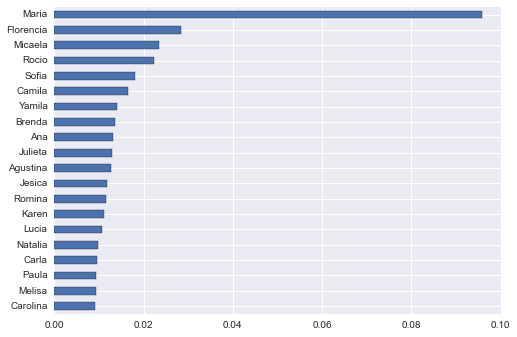

In [14]:
cba[(cba['clase'] >= 1990) & (cba['sexo'] == 'F')].primer_nombre.value_counts(normalize=True)[:20].sort(inplace=False).plot('barh');

Para las votantes más longevas, de 60 para arriba, la proporción de Marías llega al 15%

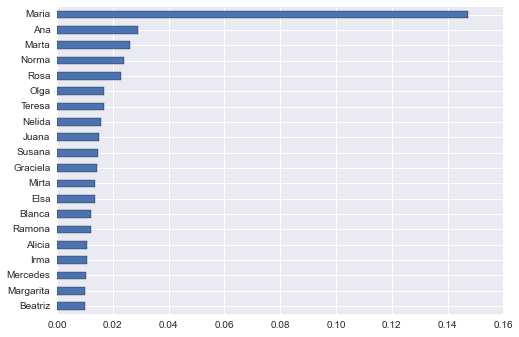

In [15]:
cba[(cba['clase'] <= 1955) & (cba['sexo'] == 'F')].primer_nombre.value_counts(normalize=True)[:20].sort(inplace=False).plot('barh');

En el caso de los hombres jóvenes, Juan es el primer nombre más común, pero seguido de cerca por Franco y Matías.

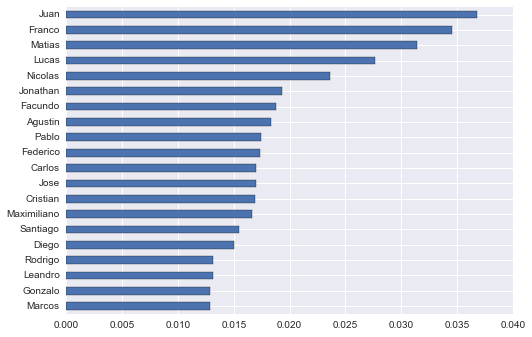

In [16]:
cba[(cba['clase'] >= 1990) & (cba['sexo'] == 'M')].primer_nombre.value_counts(normalize=True)[:20].sort(inplace=False).plot('barh');

Y entre los hombres mayores la cosa está entre Juan y José

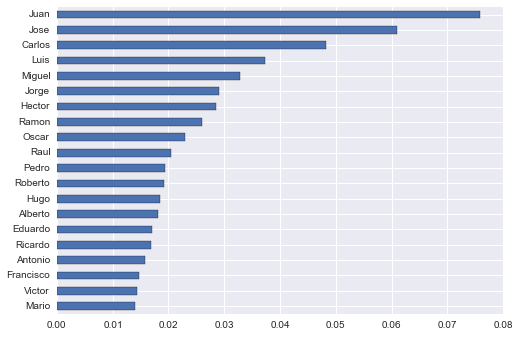

In [17]:
cba[(cba['clase'] <= 1955) & (cba['sexo'] == 'M')].primer_nombre.value_counts(normalize=True)[:20].sort(inplace=False).plot('barh');

### La generación "Y(enifer)"  

Se conoce como "[Generación Y](https://es.wikipedia.org/wiki/Generaci%C3%B3n_Y)" a los nacidos alrededor de los '90. Es justamente la generación que está en la universidad o teniendo sus primeros trabajos, y tomando con pinzas semejante generalización, parece que [tienen comportamientos particulares](http://www.lanacion.com.ar/1661962-el-desafio-de-entender-a-la-generacion-y). 

Si bien la denominación viene a cuento de ser la que sigue a la "generación X" con la que denominaba a los que nacieron entre los '60 y '80, hay una curiosidad sobresaliente: al menos en Córdoba, esta generación es muchísimo más propensa a tener nombres que comienzan con "Y" (Yanina, Yenifer, Yesica, etc.). El pico se da justamente en la clase 1990, con casi 2500 personas. 


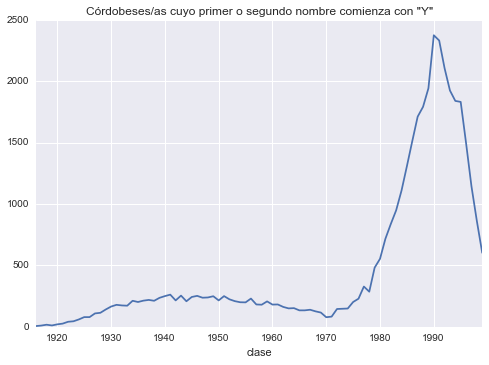

In [18]:
cba[(cba['primer_nombre'].str.startswith('Y')) | (cba['segundo_nombre'].str.startswith('Y'))].groupby('clase').apellido.count().plot()
plt.title('Córdobeses/as cuyo primer o segundo nombre comienza con "Y"');

### Nombres, muchos nombres

Parece que lo más común es que los cordobeses tengan 2 nombres, pero esa tendencia se empezó a modificar en los '80 donde la cantidad de gente con 1 sólo nombre creció.

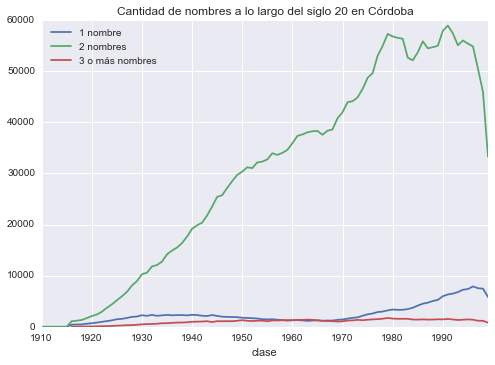

In [19]:
un_nombre = cba[(cba['segundo_nombre'] == '')].groupby('clase').apellido.count().plot(label='1 nombre')
dos_nombres = cba[(cba['tercer_nombre'] == '')].groupby('clase').apellido.count().plot(label='2 nombres')
tres_nombres = cba[(cba['tercer_nombre'] != '')].groupby('clase').apellido.count().plot(label='3 o más nombres')
plt.legend(loc='best')
plt.title('Cantidad de nombres a lo largo del siglo 20 en Córdoba');


### El nombre más típico de la clase

Si agrupásemos a todos hombres y mujeres del padrón según su edad, ¿cuál sería el nombre y apellido más probable para cada grupo?

Considerando que sólo se incluye a las personas vivas, sería una exageración decir que es el nombre más típico de ese año, pero es un indicio. 

El siguiente algoritmo busca el primer nombre, segundo nombre y apellido más probable para hombres y mujeres nacidos en cada año. Si conocen a alguien que se llame exáctamente así nacido en ese año, pueden contarle que es tiene el nombre más protípico de su clase: ¡qué originalidad! 

In [20]:
pd.set_option('display.max_rows', 200)
def nombre_del_año(sexo):
    
    nombre_por_clase = []
    for y in cba.clase.unique():
        electores = cba[(cba['clase'] == y) & (cba['sexo'] == sexo)]    
        try:
            nombre_por_clase.append([y] + [electores[attr].value_counts().index[0] for attr in \
                                               ['primer_nombre', 'segundo_nombre', 'apellido']])
        except (KeyError, IndexError):
            continue
    return pd.DataFrame(nombre_por_clase, columns=['clase', 'primer_nombre', 'segundo_nombre', 'apellido']).sort('clase')

nombre_tipico_hombres = nombre_del_año('M')
nombre_tipico_mujeres = nombre_del_año('F')

In [21]:
nombre_tipico_hombres

,clase,primer_nombre,segundo_nombre,apellido
84,1910,Miguel,,Bastus
85,1915,Hugo,,Candussi
73,1916,Jose,,Diaz
69,1917,Jose,,Gomez
32,1918,Jose,,Gomez
80,1919,Jose,,Diaz
63,1920,Jose,,Rodriguez
76,1921,Jose,,Lopez
3,1922,Jose,,Rodriguez
83,1923,Jose,,Sanchez


In [22]:
nombre_tipico_mujeres

,clase,primer_nombre,segundo_nombre,apellido
84,1911,Maria,Elvira,Frencia
87,1912,Maria,Magdalena,Rocha
88,1913,Petrona,Josefina,Coronda
86,1914,Adela,,Cena
85,1915,Maria,,Camagni
73,1916,Maria,,Gonzalez
69,1917,Maria,,Diaz
32,1918,Maria,,Gonzalez
80,1919,Maria,,Gonzalez
63,1920,Maria,,Lopez


### Comparando apellidos: Gaitán vs Lobo

De chico tenía la idea (un poco errada) de que mi apellido no muy común. Salvo algunos [casos bochornosos](http://tn.com.ar/politica/escandalo-sexual-en-neuquen-un-funcionario-intercambiaba-sexo-por-favores-en-ofici_050364), no conocí otros Gaitán en Neuquén que no sean de mi familia cercana, aunque sabía que había mucha parentela lejana en Córdoba y en otros países como Colombia era muy frecuente. 

Los Lobo, el apellido de mi mujer, en cambio, parece que son mucho menos (y crecen demográficamente a menor ritmo) de lo que la "intuición" indica. 

Comparemos:

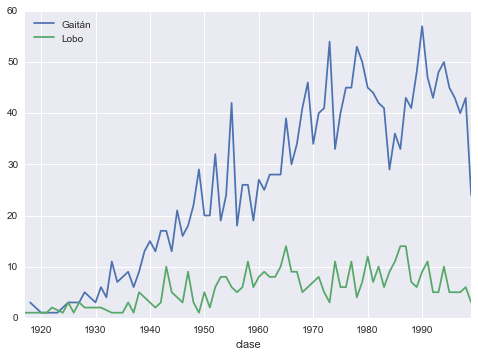

In [23]:
gaitanes = cba[(cba['apellido'] == 'Gaitan')].groupby('clase').apellido.count()
lobos = cba[(cba['apellido'] == 'Lobo')].groupby('clase').apellido.count()
gaitanes.plot(label='Gaitán'), lobos.plot(label='Lobo')
plt.legend(loc='best')

Haciendo la curva acumulada, puede verse el crecimiento absoluto de cada apellido a lo largo del siglo

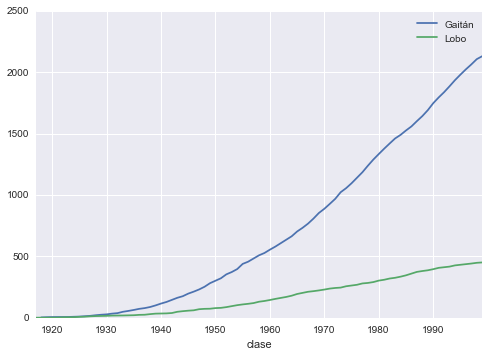

In [24]:
gaitanes.cumsum().plot(label='Gaitán'), lobos.cumsum().plot(label='Lobo')
plt.legend(loc='best');

En Córdoba somos 4 veces más los Gaitán, aunque si la muestra fuese mi familia y la de mi esposa, sería casi al reves: ¡son 9 hermanos!

## ¡Hacé tu comparación!

¿Te interesa saber cuanta gente se llama como vos? Hicimos una pequeñisima aplicación web (de [código libre](https://github.com/mgaitan/nombres_cba) que permite consultar la misma base de datos del padrón de córdoba y generar gráficos similares a los últimos para los nombres y apellidos que vos elijas. Se probar acá http://lab.opendatacordoba.org



### ¿Qué más se podría analizar?

Dado que además de la clase contamos con la sección y circuito electoral de cada votante, se podrían analizar agregaciones geolocalizadas, por ejemplo para ver el nombre más tipico de cada departamento o provincia a lo largo del tiempo como en [este estudio](http://jezebel.com/map-sixty-years-of-the-most-popular-names-for-girls-s-1443501909). 

Teniendo algunas reglas de clasificación (o mejor, una base de datos) que ponderen con algun coeficiente de procisión la procedencia de un apellido, sería posible agrupar (y geolocalizar) ¿hay algun barrio de córdoba con más personas de raíces arábigas?

Comparar gráficas entre distintas ciudades del pais abre otro sinnumero de posibilidades. Por poner un simple ejemplo *¿Cuál es la región que más proporción de niñas llamadas Eva tuvo alredodor de 1950?* *¿Qué partido ha ganado en las últimas elecciones allí?*

Por supuesto, hay cosas más interesantes y significativas de las que ocuparse, pero quisimos encontrar algunas perlitas, que puedan distendernos ante tanto spot de campaña. Y de paso mostrar que, teniendo datos, con muy pocas lineas de código se pueden responder preguntas que de otra manera sólo pueden ser contestadas con especulaciones, generandose mitos amparados en la "intuición" popular o periodística, que puede ser mucho menos precisa que una consulta a las fuentes. 
